In [ ]:
"""
structure of input:
2D array, 
if no. of columns = 2: no time dependence
format:
[metallicity in Zsun] [value on pdf/distribution on that metallicity value]
else: time dependence
format:
element [0,0] = ignored
top row = lookback time in Gyr
left column = [metallicity in Zsun]
everything else = [value on pdf/distribution on that metallicity value, at that lookback time]
Meaning: all columns integrate to 1 vertically

Step 1: check if 2 or more columns
if two columns:
get metallicity SSP bin boundaries
integrate column of pdf into each metallicity bin boundary set -> SSP weights

if more columns:
get SFH SSP bin boundaries
get metallicity SSP bin boundaries
integrate metallicity columns in input array that fall within each SSP bin boundary set into one pdf
integrate converted pdf by within each metallicity bin boundary to get SSP weights

"""

In [2]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
from scipy.optimize import curve_fit

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [3]:
spectrum = np.loadtxt(fname='../../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                      "2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test"+".csv", 
                      delimiter=',', skiprows=1)
obs_wavs = spectrum[:,0]

In [43]:
pipes.config.zmet_sampling = np.arange(0., 10., 0.01) + 0.005
import bagpipes.config as config

def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            if 'metallicity_type' not in model_comp[comp].keys():
                self.grid_comp[comp] = self.delta(model_comp[comp],
                                                  sfh_weights[comp])
            else:
                self.grid_comp[comp] = getattr(self, model_comp[comp]['metallicity_type']
                                              )(model_comp[comp],sfh_weights[comp])

            self.grid += self.grid_comp[comp]
    global grid_comp 
    grid_comp = self.grid

def _cal_zmet_weights(self, zmet_vals, zmet_weights):
    # add interpolated metallicity distribution values at the zmet_lims
    weights_to_add = np.interp(self.zmet_lims, zmet_vals, zmet_weights)
    new_zmet_vals = np.hstack([zmet_vals, self.zmet_lims])
    new_zmet_weights = np.hstack([zmet_weights, weights_to_add])
    sort_ind = new_zmet_vals.argsort()
    new_zmet_vals = new_zmet_vals[sort_ind]
    new_zmet_weights = new_zmet_weights[sort_ind]

    weights = np.zeros(self.zmet_vals.shape[0])

    for i in range(weights.shape[0]):
        lowmask = (new_zmet_vals >= self.zmet_lims[i])
        highmask = (new_zmet_vals <= self.zmet_lims[i+1])
        xvals = new_zmet_vals[lowmask & highmask]
        yvals = new_zmet_weights[lowmask & highmask]
        weights[i] = np.trapz(y=yvals, x=xvals)
        
    return weights
    
def custom(self, comp, sfh):
    """
    Like the custom option in SFH, an option that is only used in model-generation
    to create spectra based on completely user-defined custom CEH/metallicity
    arrays. Supports both just a time-independent metallicity scatter distribution
    and a time-dependent metallicity evolution with varying scatter.
    """
    zmet_param = comp["metallicity_array"]
    if isinstance(zmet_param, str):
        zmet_array = np.loadtxt(zmet_param)

    else:
        zmet_array = zmet_param
    
    # no time-dependence, shape = (n,2)
    if np.shape(zmet_array)[1] == 2:
        print('mode a')
        # add interpolated metallicity distribution values at the zmet_lims
        weights = self._cal_zmet_weights(zmet_array[:,0], zmet_array[:,1])
        
        return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)
        
    # only time-dependence, no scatter, shape = (2,m)
    elif np.shape(zmet_array)[1] > 2 and np.shape(zmet_array)[0] == 2:
        print('mode b')
        SSP_ages = config.age_sampling
        SSP_age_bins = config.age_bins
        
        # add interpolated metallicity values at the SSP_age_bins
        vals_to_add = np.interp(SSP_age_bins, zmet_array[0], zmet_array[1])
        new_array = np.hstack([zmet_array.copy(), np.vstack([SSP_age_bins,vals_to_add])])
        new_array = new_array[:,new_array[0].argsort()]
        
        zmet_comp = np.zeros((self.zmet_vals.shape[0], sfh.shape[0]))
        SSP_zmet = np.zeros(sfh.shape[0])
        for i in range(SSP_ages.shape[0]):
            lowmask = (new_array[0] >= SSP_age_bins[i])
            highmask = (new_array[0] <= SSP_age_bins[i+1])
            this_SSP_ages = new_array[0,lowmask & highmask]
            this_SSP_zmet = np.trapz(y=new_array[1,lowmask & highmask], x=this_SSP_ages)
            this_SSP_zmet = this_SSP_zmet/(max(this_SSP_ages)-min(this_SSP_ages))
            
            SSP_zmet[i] = this_SSP_zmet
            
            zmet_comp[:,i] = self.delta(comp, sfh, zmet=this_SSP_zmet, nested=True)
            
        fig,ax = plt.subplots(figsize=[20,10])
        plt.plot(np.log10(zmet_array[0]), zmet_array[1], color='k')
        plt.plot(np.log10(new_array[0]), new_array[1], 'b.')
        plt.plot(np.log10(SSP_ages), SSP_zmet, marker='.', color='sandybrown')
        for bini in SSP_age_bins:
            plt.axvline(np.log10(bini), color='k', alpha=0.5)
        plt.show()
            
        return zmet_comp*np.expand_dims(sfh, axis=0)
    
    # full grid, both time-dependence and scatter, shape = (n,m)
    elif np.shape(zmet_array)[1] > 2 and np.shape(zmet_array)[0] > 2:
        print('mode c')
        age_bins = zmet_array[0,1:]
        zmet_bins = zmet_array[1:,0]
        weights_only_array = zmet_array[1:,1:]
        
        SSP_ages = config.age_sampling
        #SSP_ages = np.linspace(0,max(config.age_sampling),101)
        SSP_age_bins = config.age_bins
        #SSP_age_bins = pipes.utils.make_bins(SSP_ages, make_rhs=True)[0]
        
        # add interpolated columns of metallicity weights at the SSP_age_bins
        vals_to_add_array = np.zeros([len(zmet_bins), len(SSP_age_bins)])
        for i in range(len(zmet_bins)):
            vals_to_add_array[i] = np.interp(SSP_age_bins, age_bins, weights_only_array[i])
        new_weights = np.hstack([weights_only_array.copy(), vals_to_add_array])
        new_age_bins = np.hstack([age_bins.copy(), SSP_age_bins])
        sort_ind = new_age_bins.argsort()
        new_age_bins = new_age_bins.copy()[sort_ind]
        new_weights = new_weights.copy()[:,sort_ind]
        
        fig, ax = plt.subplots(figsize=[20,10])
        zmet_comp = np.zeros((self.zmet_vals.shape[0], SSP_ages.shape[0]))
        for i in range(SSP_ages.shape[0]):
            lowmask = (new_age_bins >= SSP_age_bins[i])
            highmask = (new_age_bins <= SSP_age_bins[i+1])
            this_SSP_ages = new_age_bins[lowmask & highmask]
            this_SSP_array = new_weights[:,lowmask & highmask]
            
            # take the sum metallicity weights among different age bins
            this_SSP_weights = np.zeros(len(zmet_bins))
            for j in range(len(zmet_bins)):
                this_SSP_weights[j] = np.trapz(y=this_SSP_array[j,:], x=this_SSP_ages)
            #print(this_SSP_weights)
            age_frac = SSP_ages[i]/max(SSP_ages)
            plt.plot(zmet_bins, this_SSP_weights, color=(age_frac,0,1-age_frac), zorder=1-age_frac)
            
            this_SSP_weights = this_SSP_weights/np.trapz(y=this_SSP_weights, x=zmet_bins)
                
            # calculate SSP metallicity weights for each age SSP
            zmet_comp[:,i] = self._cal_zmet_weights(zmet_bins, this_SSP_weights)
        
        plt.show()
        return zmet_comp*np.expand_dims(sfh, axis=0)

def delta(self, comp, sfh, zmet=None, nested=False):
    """ Delta function metallicity history. """

    if zmet is None:
        zmet = comp["metallicity"]

    weights = np.zeros(self.zmet_vals.shape[0])

    high_ind = self.zmet_vals[self.zmet_vals < zmet].shape[0]

    if high_ind == self.zmet_vals.shape[0]:
        weights[-1] = 1.

    elif high_ind == 0:
        weights[0] = 1.

    else:
        low_ind = high_ind - 1
        width = (self.zmet_vals[high_ind] - self.zmet_vals[low_ind])
        weights[high_ind] = (zmet - self.zmet_vals[low_ind])/width
        weights[high_ind-1] = 1 - weights[high_ind]

    if nested:
        return weights
    else:
        return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)

def exp(self, comp, sfh, zmet=None, nested=False):
    """ P(Z) = exp(-z/z_mean). Currently no age dependency! """

    if zmet is None:
        tau_zmet = comp["metallicity"]
    else:
        tau_zmet = zmet

    weights = np.zeros(self.zmet_vals.shape[0])

    vals_hr = np.arange(0., 10., 0.01) + 0.005

    factors_hr = (1./tau_zmet)*np.exp(-vals_hr/tau_zmet)

    for i in range(weights.shape[0]):
        lowmask = (vals_hr > self.zmet_lims[i])
        highmask = (vals_hr < self.zmet_lims[i+1])
        weights[i] = np.sum(0.01*factors_hr[lowmask & highmask])

    if nested:
        return weights
    else:
        return np.expand_dims(weights, axis=1)*np.expand_dims(sfh, axis=0)
    
pipes.models.chemical_enrichment_history.__init__ = __init__
pipes.models.chemical_enrichment_history.custom = custom
pipes.models.chemical_enrichment_history.exp = exp
pipes.models.chemical_enrichment_history.delta = delta
pipes.models.chemical_enrichment_history._cal_zmet_weights = _cal_zmet_weights

0.995388761167844


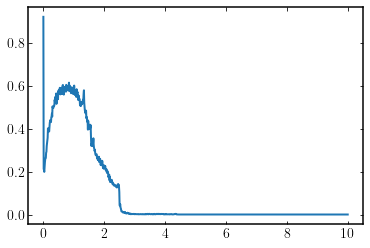

mode a
mode a


In [256]:
# toy model for testing
constant = {}
constant["massformed"] = 10
constant["age_max"] = 10
constant["age_min"] = 1

# read in overall scatter of Yirui's simulations
zmet_array = np.loadtxt('../../../Yirui_test_cube/simulation_info/overall_metallicity_scatter.txt')
print(np.trapz(y=zmet_array[:,1], x=zmet_array[:,0]))
plt.plot(zmet_array[:,0], zmet_array[:,1])
plt.show()

constant["metallicity_type"] = "custom"
constant["metallicity_array"] = '../../../Yirui_test_cube/simulation_info/overall_metallicity_scatter.txt'

model_components = {}
model_components['constant'] = constant
model_components['redshift'] = 0.04

flat_dist = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)

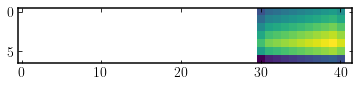

In [257]:
from matplotlib.colors import LogNorm
plt.imshow(flat_dist.sfh.ceh.grid, norm=LogNorm())
plt.show()

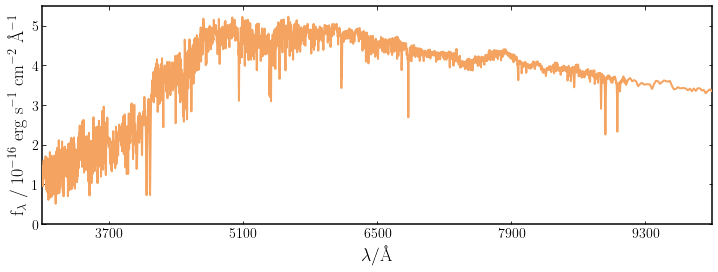

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [258]:
flat_dist.plot()

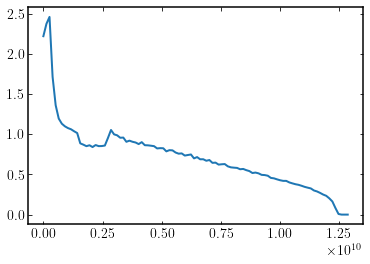

mode b
mode b


In [261]:
# toy model for testing
constant = {}
constant["massformed"] = 10
constant["age_max"] = 10
constant["age_min"] = 1

# constant increase in metallicity, no scatter
#ages = np.linspace(0,cosmo.age(0.04).value,1000)*10**9
#metallicities = np.linspace(0,1,1000)[::-1] * 1.5
zmet_array = np.loadtxt('../../../Yirui_test_cube/simulation_info/median_metallicity.txt')
ages = zmet_array[0]
metallicities = zmet_array[1]

plt.plot(ages, metallicities)
plt.show()

constant["metallicity_type"] = "custom"
constant["metallicity_array"] = '../../../Yirui_test_cube/simulation_info/median_metallicity.txt'

model_components2 = {}
model_components2['constant'] = constant
model_components2['redshift'] = 0.04

no_scatter = pipes.model_galaxy(model_components2, spec_wavs=obs_wavs)

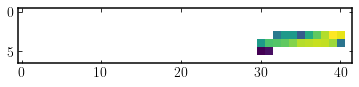

In [262]:
from matplotlib.colors import LogNorm
plt.imshow(no_scatter.sfh.ceh.grid, norm=LogNorm())
plt.show()

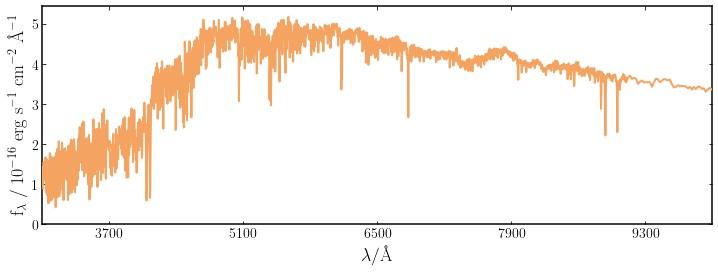

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [263]:
no_scatter.plot()

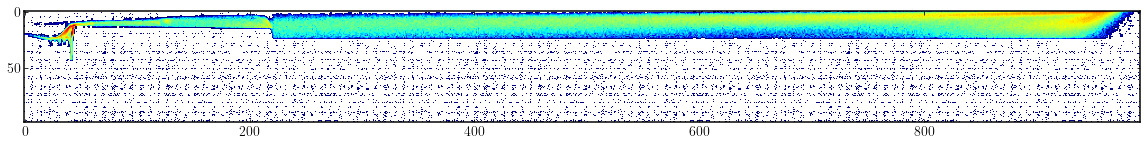

mode c


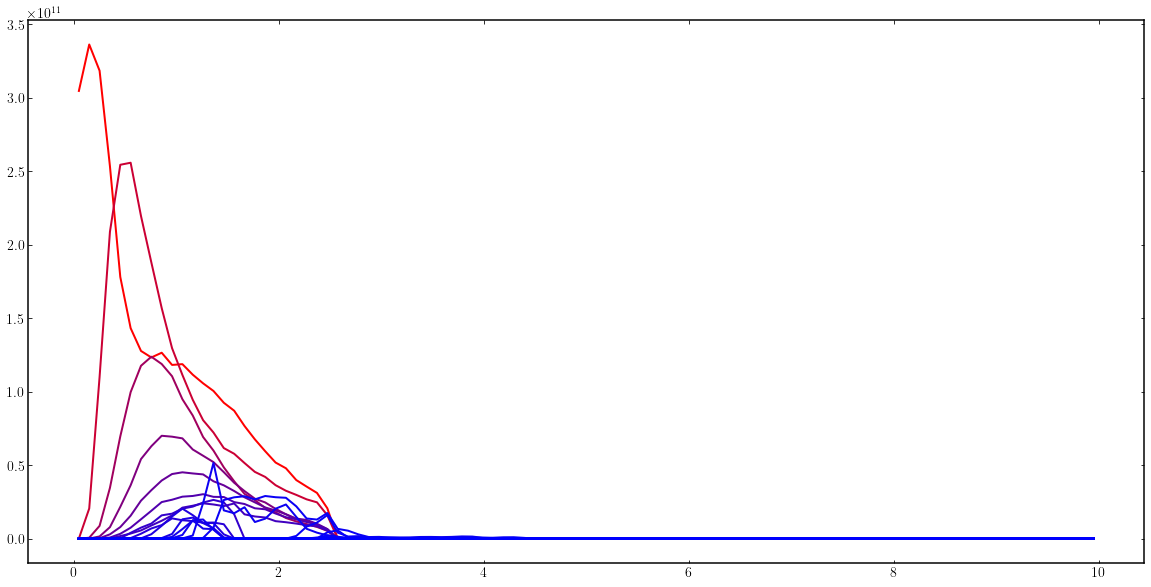

mode c


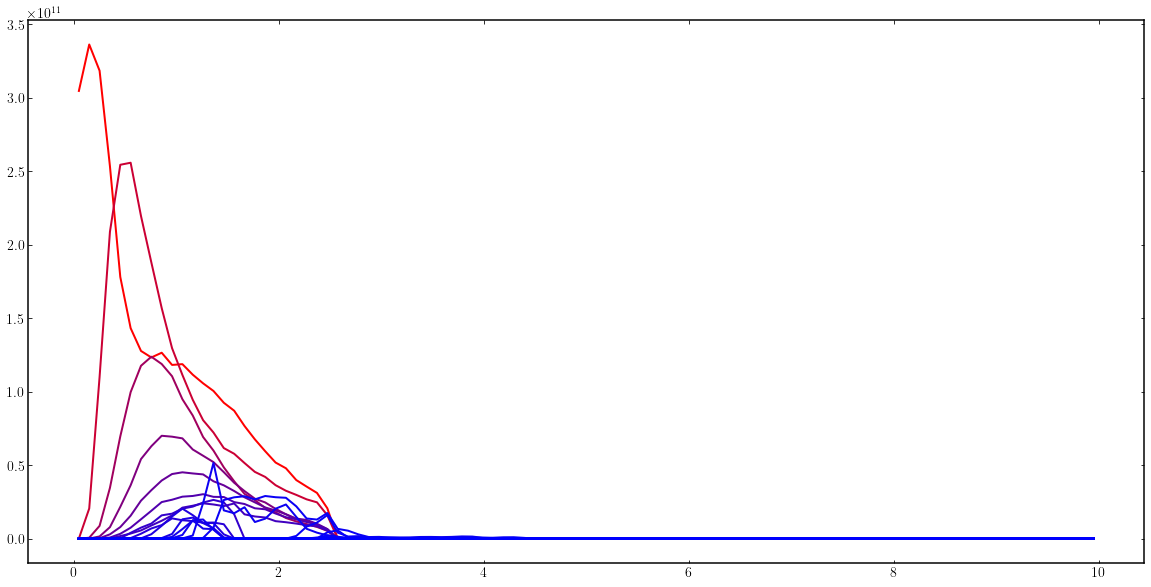

In [264]:
# toy model for testing
constant = {}
constant["massformed"] = 10
constant["age_max"] = 10
constant["age_min"] = 1

# constant increase in metallicity, no scatter
zmet_array = np.loadtxt('../../../Yirui_test_cube/simulation_info/full_metallicity_scatter.txt')
fig, ax = plt.subplots(figsize=[20,5])
plt.imshow(zmet_array[1:,1:], cmap='jet', norm=LogNorm())
plt.show()

constant["metallicity_type"] = "custom"
constant["metallicity_array"] = '../../../Yirui_test_cube/simulation_info/full_metallicity_scatter.txt'

model_components3 = {}
model_components3['constant'] = constant
model_components3['redshift'] = 0.04

full_model = pipes.model_galaxy(model_components3, spec_wavs=obs_wavs)

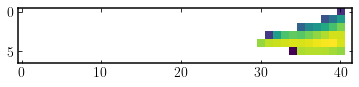

In [265]:
from matplotlib.colors import LogNorm
plt.imshow(full_model.sfh.ceh.grid, norm=LogNorm())
plt.show()

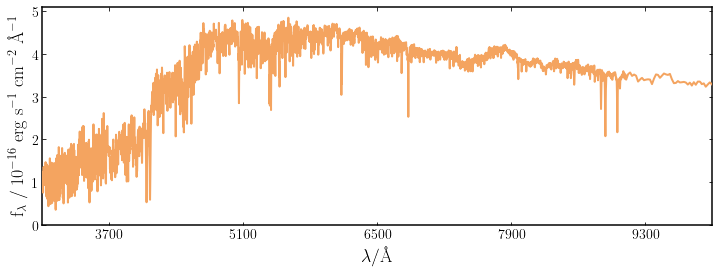

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [266]:
full_model.plot()

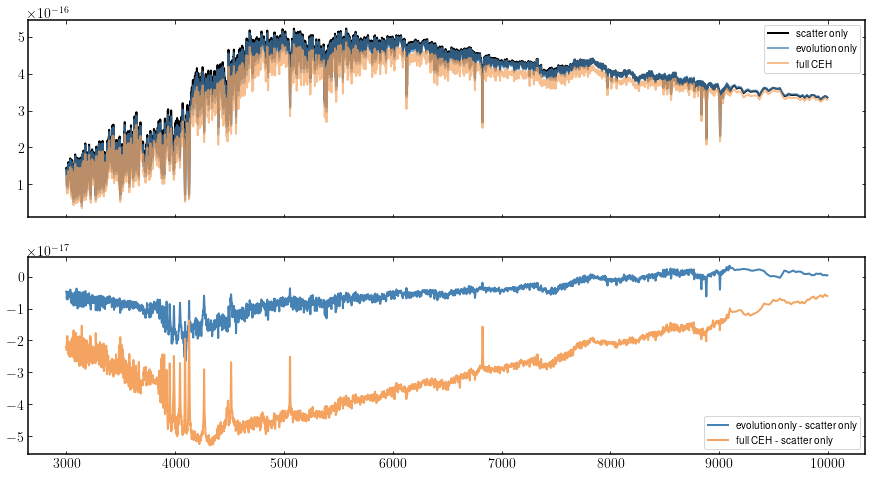

In [267]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, flat_dist.spectrum[:,1], label='scatter only', color='black')
ax[0].plot(obs_wavs, no_scatter.spectrum[:,1], label='evolution only', color='steelblue', alpha=0.7)
ax[0].plot(obs_wavs, full_model.spectrum[:,1], label='full CEH', color='sandybrown', alpha=0.7)
ax[0].legend()
ax[1].plot(obs_wavs, no_scatter.spectrum[:,1] - flat_dist.spectrum[:,1], color='steelblue', 
           label="evolution only - scatter only")
ax[1].plot(obs_wavs, full_model.spectrum[:,1] - flat_dist.spectrum[:,1], color='sandybrown', 
           label="full CEH - scatter only")
ax[1].legend()

plt.show()

In [5]:
# load in true SFH
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

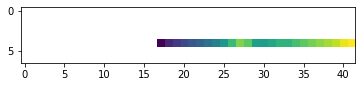

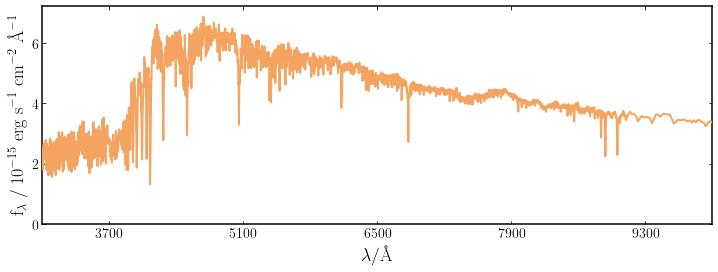

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [7]:
# baseline model with just Yirui's true SFH, default CEH at solar metallicity
custom = {}
custom["massformed"] = 11.027233041278691
custom["history"] = np.vstack([model_ages*10**9, model_sfh]).T
custom["metallicity"] = 1.0
mc0 = {}
mc0["custom"] = custom
mc0["redshift"] = 0.04

yirui_baseline = pipes.model_galaxy(mc0, spec_wavs=obs_wavs)

from matplotlib.colors import LogNorm
plt.imshow(yirui_baseline.sfh.ceh.grid, norm=LogNorm())
plt.show()

yirui_baseline.plot()

mode a
mode a


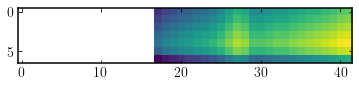

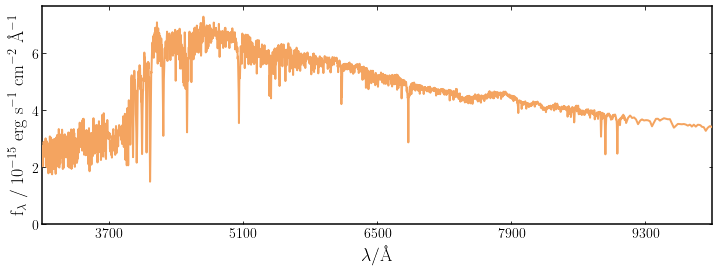

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [8]:
# actual model with Yirui's true SFH passed through custom SFH component in Bagpipes
custom = {}
custom["massformed"] = 11.027233041278691
custom["history"] = np.vstack([model_ages*10**9, model_sfh]).T
custom["metallicity_type"] = "custom"
custom["metallicity_array"] = '../../../Yirui_test_cube/simulation_info/overall_metallicity_scatter.txt'

mc1 = {}
mc1["custom"] = custom
mc1["redshift"] = 0.04

yirui_scatter_only = pipes.model_galaxy(mc1, spec_wavs=obs_wavs)

plt.imshow(yirui_scatter_only.sfh.ceh.grid, norm=LogNorm())
plt.show()

yirui_scatter_only.plot()

mode b


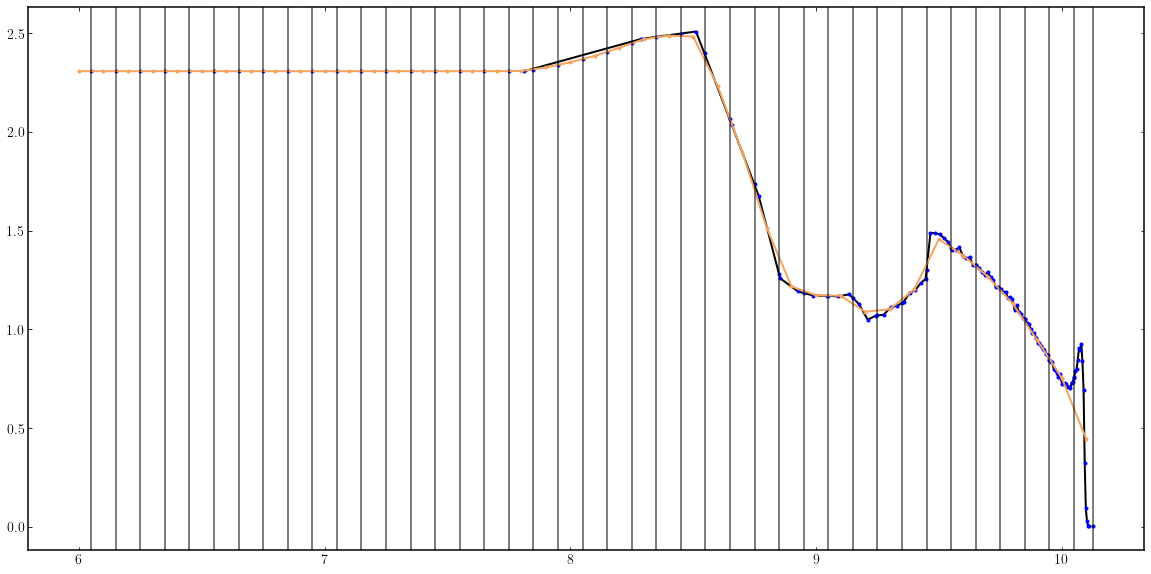

mode b


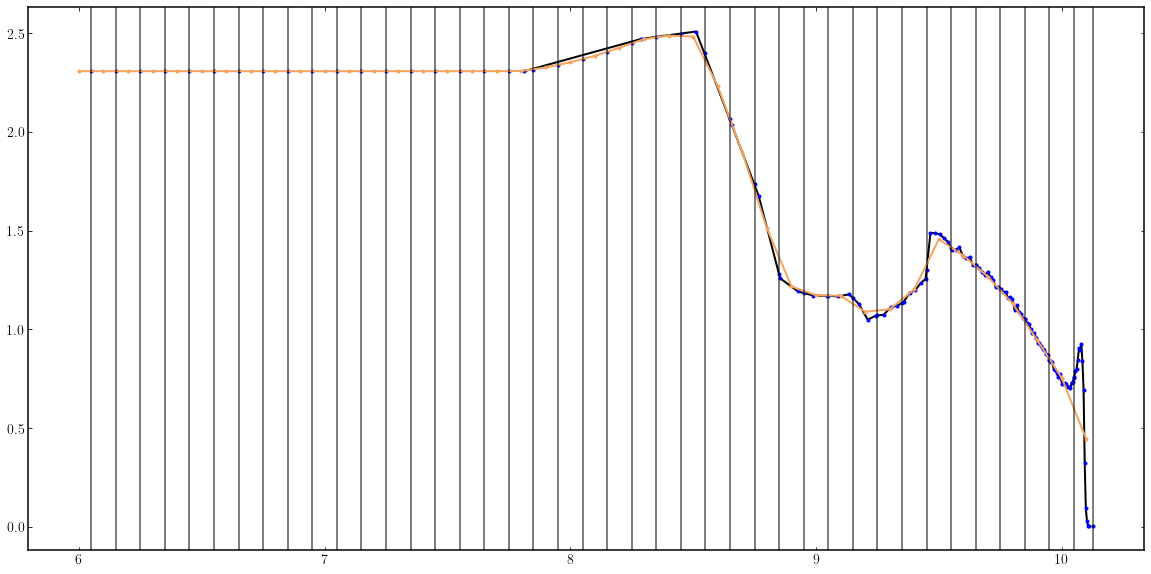

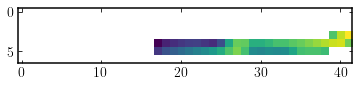

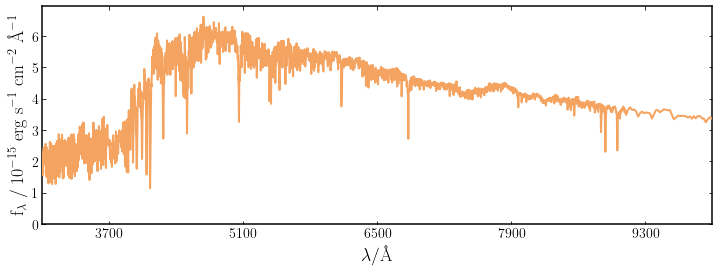

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [78]:
# actual model with Yirui's true SFH passed through custom SFH component in Bagpipes
custom = {}
custom["massformed"] = 11.027233041278691
custom["history"] = np.vstack([model_ages*10**9, model_sfh]).T
custom["metallicity_type"] = "custom"
custom["metallicity_array"] = '../../../Yirui_test_cube/simulation_info/median_metallicity.txt'

mc2 = {}
mc2["custom"] = custom
mc2["redshift"] = 0.04

yirui_evolution_only = pipes.model_galaxy(mc2, spec_wavs=obs_wavs)

plt.imshow(yirui_evolution_only.sfh.ceh.grid, norm=LogNorm())
plt.show()

yirui_evolution_only.plot()

mode c


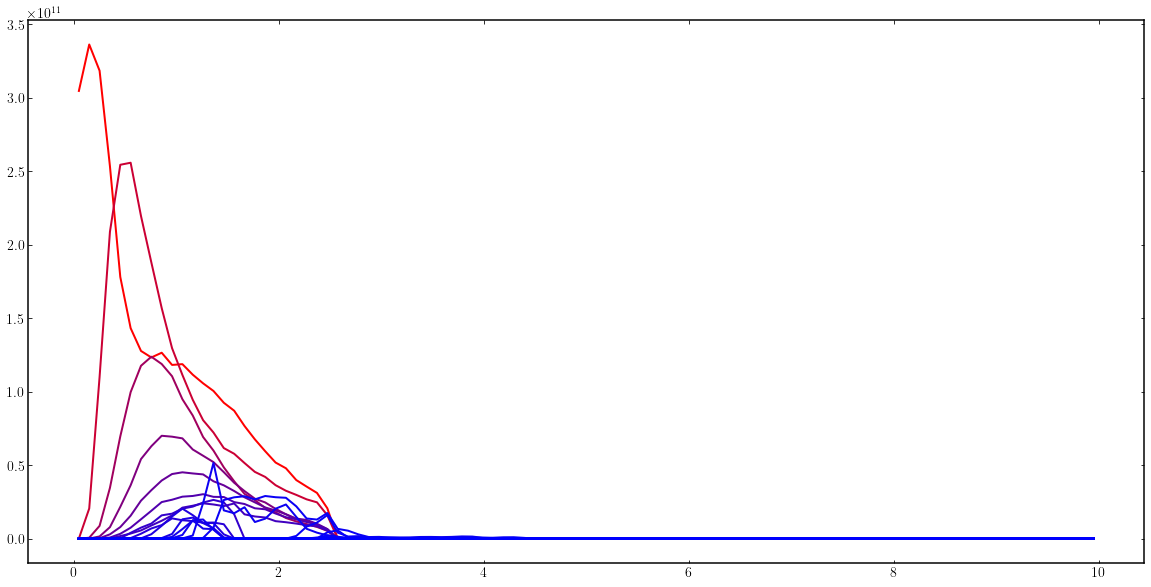

mode c


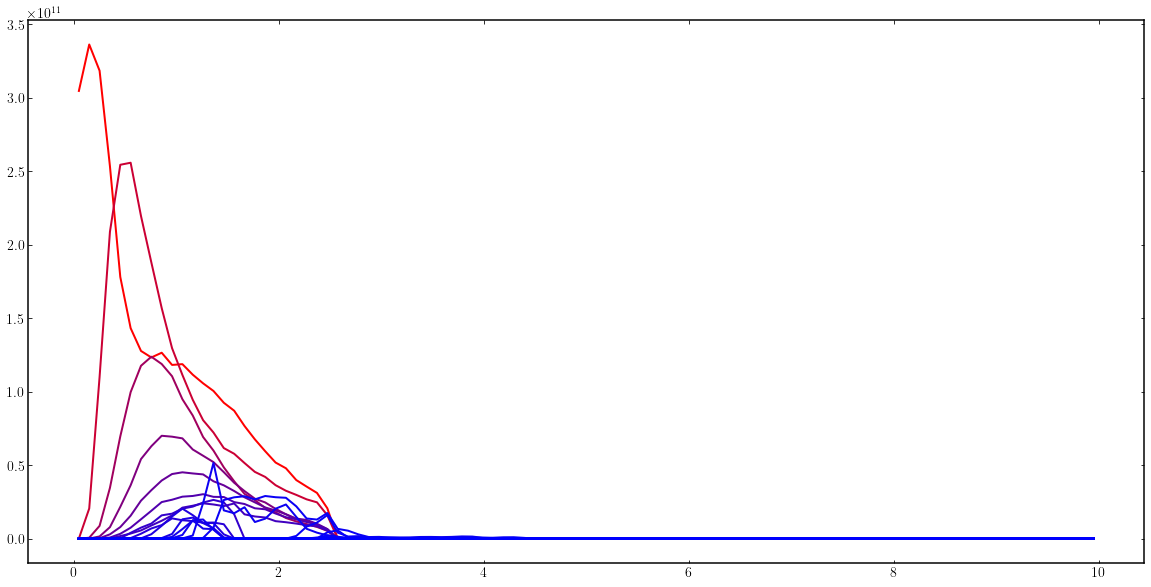

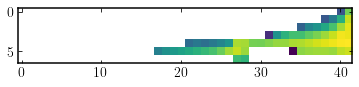

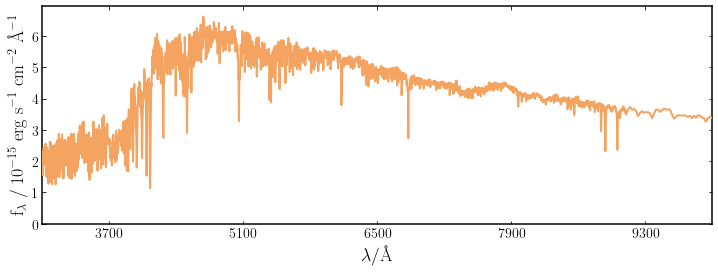

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [10]:
# actual model with Yirui's true SFH passed through custom SFH component in Bagpipes
custom = {}
custom["massformed"] = 11.027233041278691
custom["history"] = np.vstack([model_ages*10**9, model_sfh]).T
custom["metallicity_type"] = "custom"
custom["metallicity_array"] = '../../../Yirui_test_cube/simulation_info/full_metallicity_scatter.txt'

mc3 = {}
mc3["custom"] = custom
mc3["redshift"] = 0.04

yirui_full_model = pipes.model_galaxy(mc3, spec_wavs=obs_wavs)

plt.imshow(yirui_full_model.sfh.ceh.grid, norm=LogNorm())
plt.show()

yirui_full_model.plot()

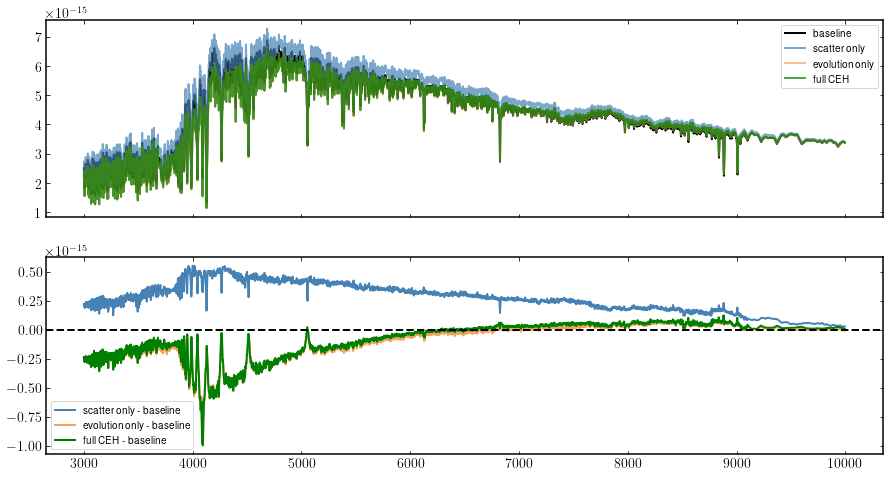

In [79]:
fig, ax = plt.subplots(2,1, figsize=[15,8], sharex=True)
ax[0].plot(obs_wavs, yirui_baseline.spectrum[:,1], label='baseline', color='black')
ax[0].plot(obs_wavs, yirui_scatter_only.spectrum[:,1], label='scatter only', color='steelblue', alpha=0.7)
ax[0].plot(obs_wavs, yirui_evolution_only.spectrum[:,1], label='evolution only', color='sandybrown', alpha=0.7)
ax[0].plot(obs_wavs, yirui_full_model.spectrum[:,1], label='full CEH', color='green', alpha=0.7)
ax[0].legend()
ax[1].plot(obs_wavs, yirui_scatter_only.spectrum[:,1] - yirui_baseline.spectrum[:,1], color='steelblue', 
           label="scatter only - baseline")
ax[1].plot(obs_wavs, yirui_evolution_only.spectrum[:,1] - yirui_baseline.spectrum[:,1], color='sandybrown', 
           label="evolution only - baseline")
ax[1].plot(obs_wavs, yirui_full_model.spectrum[:,1] - yirui_baseline.spectrum[:,1], color='green', 
           label="full CEH - baseline")
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')

plt.show()

In [80]:
# save the spectra for further fitting
def gen_save_name(fileseq, snap, with_dust, with_noise, remarks=None):
    directory = '../../../Yirui_test_cube/snap'+str(snap)+'_bagpipes_model/'
    save_name = 'Spectrum_'+fileseq
    if with_dust == True:
        directory += 'with_dust/'
        save_name += '_with_dust'
    else:
        directory += 'no_dust/'
        save_name += '_no_dust'
    if with_noise == True:
        save_name += '_with_noise'
    if remarks is not None:
        if remarks[0] == '_':
            save_name += remarks
        else: save_name += '_'+remarks
    save_name += '.csv'
    return directory+save_name

def noise_and_error(spectrum, SNR, noise):
    #setting spectrum obs error to be 15% of flux density
    spectrum_err = spectrum/SNR
    
    if noise == True:
        #adding artificial noise to the spectrum according to the SNR set
        #noise added is gaussian with sigma = signal/SNR
        spectrum_1sigma = spectrum/SNR
        spectrum_ = spectrum+np.random.randn(len(spectrum_1sigma))*spectrum_1sigma
    else:
        spectrum_ = spectrum
    return spectrum_, spectrum_err

SNR = 15
noise = False

fileseq = ['uniformZ', 'scatter_only', 'evolution_only', 'full_ceh']
snap = 119
dust = False
remarks = "SNR15"

for i,model in enumerate([yirui_baseline, yirui_scatter_only, yirui_evolution_only, yirui_full_model]):
    spectrum_, spectrum_err = noise_and_error(model.spectrum[:,1], SNR, noise)
    save_df = pd.DataFrame({'observed-wave[AA]':obs_wavs,'flux[10^-16 erg/s/cm^2/AA]':spectrum_*10**16, 'noise[10^-16 erg/s/cm^2/AA]':spectrum_err*10**16})
    save_name = gen_save_name(fileseq[i], snap, dust, noise, remarks=remarks)
    print(save_name)
    save_df[save_df['observed-wave[AA]'].between(3000,10000)].to_csv(save_name, index=False)

../../../Yirui_test_cube/snap119_bagpipes_model/no_dust/Spectrum_uniformZ_no_dust_SNR15.csv
../../../Yirui_test_cube/snap119_bagpipes_model/no_dust/Spectrum_scatter_only_no_dust_SNR15.csv
../../../Yirui_test_cube/snap119_bagpipes_model/no_dust/Spectrum_evolution_only_no_dust_SNR15.csv
../../../Yirui_test_cube/snap119_bagpipes_model/no_dust/Spectrum_full_ceh_no_dust_SNR15.csv


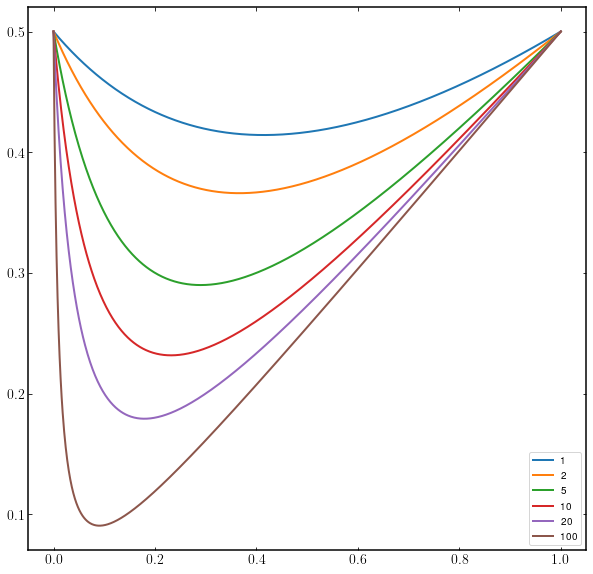

In [86]:
height = 1
can_density = 1
density_ratio = 10

def cal_COM(density_ratio):
    liquid_level = np.linspace(0,1,1000)
    COM = (1+liquid_level**2*density_ratio) / (2*(1+density_ratio*liquid_level))
    return COM

min_h = []
fig, ax = plt.subplots(figsize=[10,10])
for i in [1,2,5,10,20,100]:
    plt.plot(np.linspace(0,1,1000), cal_COM(i), label=i)
    min_h.append(np.linspace(0,1,1000)[np.argmin(cal_COM(i))])
plt.legend()
plt.show()


0.009900499987500625


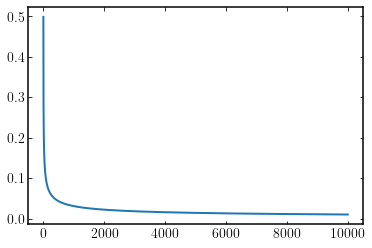

In [93]:
rho = 10**np.linspace(np.log10(0.01),np.log10(10000),1000)
min_h = (np.sqrt(rho+1)-1)/rho

plt.plot(rho, min_h)
#plt.xscale('log')
print(min(min_h))